<table width="100%" style="border:none">
  <tr>
    <td valign="top">
      <h1>GTEx RNAseq SABV Analysis</h1>
      <ul>
<li>Author: Jeremy Yang
<li>Based on R code by Oleg Ursu.
<li>Required: Python3, Pandas 0.22+
<li>Input reshaped, derived GTEx RNAseq expression data.
<li>Compute log fold-change per gene+tissue.
<li>Compute tissue specificity index (Yanai et al., 2004).
      </ul>
[About Colaboratory](https://research.google.com/colaboratory/faq.html).    
    </td>
    <td align="right">
        <p>NIH Data Commons: Team Helium</p>
<img style="float:right" width="100" src="https://avatars2.githubusercontent.com/u/33356654?s=200&v=4" alt="HeliumDataCommons Logo" />
    </td>
  </tr>
  </table>
 

In [1]:
import sys,os,re,time,io
import urllib.request
import google.colab
import numpy,scipy
import pandas
print('Python: %s; Pandas: %s; Scipy: %s ; Numpy: %s'%(sys.version.split()[0],pandas.__version__,scipy.__version__,numpy.__version__))

Python: 3.6.3; Pandas: 0.22.0; Scipy: 0.19.1 ; Numpy: 1.14.5


### Upload Median TPMs datafile:

In [4]:
print('Upload Median TPMs datafile: ')
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
tpms = pandas.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t')
print("dataset nrows: %d ; ncols: %d:"%(tpms.shape[0],tpms.shape[1]), file=sys.stderr)

Upload Median TPMs datafile: 


Saving gtex_rnaseq_prep_median.tsv to gtex_rnaseq_prep_median (2).tsv
Uploaded "gtex_rnaseq_prep_median.tsv" with 316310 bytes


dataset nrows: 6656 ; ncols: 4:


In [5]:
tpms.head()

,ENSG,SMTSD,SEX,TPM
0,ENSG00000039139.9,Adipose - Subcutaneous,female,0.078
1,ENSG00000039139.9,Adipose - Subcutaneous,male,0.074
2,ENSG00000039139.9,Adipose - Visceral (Omentum),female,0.053
3,ENSG00000039139.9,Adipose - Visceral (Omentum),male,0.064
4,ENSG00000039139.9,Adrenal Gland,female,0.079


### Read tissues files with groups

### Read and merge gene symbols.
File from https://www.ensembl.org/biomart, dataset human genes, fields Gene stable ID, Gene stable ID version,  NCBI gene ID, HGNC symbol.

In [6]:
print('Upload Biomart ENSG2NCBI genes datafile: ')
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
genes = pandas.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t', usecols=[1,2,3], na_values=[''], dtype={2:str})
genes.columns = ['ENSG','NCBI','HGNC']
genes.dropna(inplace=True)

Upload Biomart ENSG2NCBI genes datafile: 


Saving biomart_ENSG2NCBI.tsv to biomart_ENSG2NCBI (1).tsv
Uploaded "biomart_ENSG2NCBI.tsv" with 2786143 bytes


In [7]:
genes.head()

,ENSG,NCBI,HGNC
1,ENSG00000211459.2,4549,MT-RNR1
3,ENSG00000210082.2,4550,MT-RNR2
5,ENSG00000198888.2,4535,MT-ND1
9,ENSG00000198763.3,4536,MT-ND2
15,ENSG00000198804.2,4512,MT-CO1


In [8]:
tpms = pandas.merge(tpms, genes, on=["ENSG"], how="left")
tpms.head()

,ENSG,SMTSD,SEX,TPM,NCBI,HGNC
0,ENSG00000039139.9,Adipose - Subcutaneous,female,0.078,1767,DNAH5
1,ENSG00000039139.9,Adipose - Subcutaneous,male,0.074,1767,DNAH5
2,ENSG00000039139.9,Adipose - Visceral (Omentum),female,0.053,1767,DNAH5
3,ENSG00000039139.9,Adipose - Visceral (Omentum),male,0.064,1767,DNAH5
4,ENSG00000039139.9,Adrenal Gland,female,0.079,1767,DNAH5


### LOG10(TPM+1) useful transformation.

In [0]:
tpms['LOG_TPM'] = tpms.TPM.apply(lambda x: numpy.log10(x+1))

In [11]:
tpms.describe()

,TPM,LOG_TPM
count,6656.000000,6656.000000
mean,22.228046,0.372169
std,643.466588,0.567178
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.136500,0.055569
75%,2.696500,0.567791
max,37325.000000,4.572011


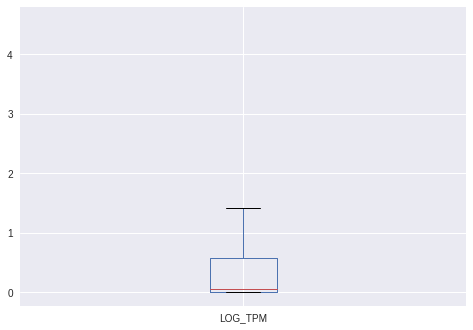

In [13]:
tpms.plot.box(y='LOG_TPM')

### Compute TAU, tissue specificity index (Yanai et al., 2004), for each gene.

> ## $ \tau = \frac{\sum_{i=0}^N (1 - x_i)}{N - 1} $

> * N = number of tissues
> * x = expression profile component normalized by the maximal component value

Validate with example vector from paper.  Should be 0.95.



In [14]:
def TAU(X):
  N = len(X)
  xmax = max(X)
  if xmax==0: return(0.0)
  tau = 0.0
  for x in X:
    tau += (1 - x/xmax)
  tau /= (N - 1)
  return(tau)
print('%.2f'%TAU([0,8,0,0,0,2,0,2,0,0,0,0]))

0.95


In [15]:
tpms_tau = tpms.groupby(['ENSG']).TPM.agg(TAU)
tpms_tau = pandas.DataFrame(tpms_tau).rename(columns={'TPM':'TAU'})
tpms_tau = tpms_tau.reset_index(drop=False)
tpms_tau.head()

,ENSG,TAU
0,ENSG00000039139.9,0.871812
1,ENSG00000082516.8,0.454276
2,ENSG00000100302.6,0.848097
3,ENSG00000100580.7,0.602530
4,ENSG00000101200.5,0.915924


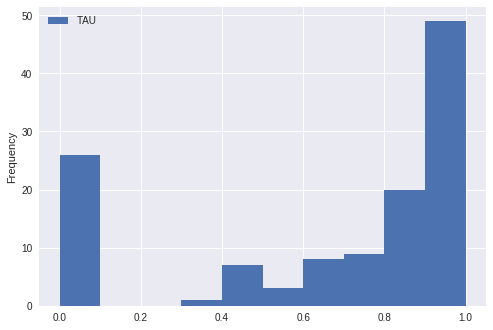

In [16]:
tpms_tau.plot.hist(y='TAU')

### Assign gene-tissue rank (quantile) among tissues.
Low-Med-High cutoff quantiles: .25 and .75.  These ranks measure, for a given gene, relative tissue expression from the gene-tissue TPMs.

In [0]:
def GTRanks(tpms, tpm_col):
  tpm_rank = pandas.Series(dtype="float", index=range(tpms.shape[0]))
  for i in tpms.index:
    ensg = tpms.ENSG[i]
    val_this = tpms[tpm_col][i]
    vals_ensg = tpms[tpm_col][tpms.ENSG==ensg]
    vals_ensg = vals_ensg.sort_values().reset_index(drop=True)
    j = vals_ensg[vals_ensg == val_this].index[0]
    tpm_rank.iloc[i] = j/vals_ensg.size 

  tpms[tpm_col+'_RANK'] = tpm_rank
  return(tpms)

In [18]:
tpms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6656 entries, 0 to 6655
Data columns (total 7 columns):
ENSG       6656 non-null object
SMTSD      6656 non-null object
SEX        6656 non-null object
TPM        6656 non-null float64
NCBI       6656 non-null object
HGNC       6656 non-null object
LOG_TPM    6656 non-null float64
dtypes: float64(2), object(5)
memory usage: 416.0+ KB


In [19]:
t0 = time.time()
tpms_ranks = GTRanks(tpms.copy(), 'TPM')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks.head()

Elapsed: 12s


,ENSG,SMTSD,SEX,TPM,NCBI,HGNC,LOG_TPM,TPM_RANK
0,ENSG00000039139.9,Adipose - Subcutaneous,female,0.078,1767,DNAH5,0.032619,0.316667
1,ENSG00000039139.9,Adipose - Subcutaneous,male,0.074,1767,DNAH5,0.031004,0.250000
2,ENSG00000039139.9,Adipose - Visceral (Omentum),female,0.053,1767,DNAH5,0.022428,0.116667
3,ENSG00000039139.9,Adipose - Visceral (Omentum),male,0.064,1767,DNAH5,0.026942,0.150000
4,ENSG00000039139.9,Adrenal Gland,female,0.079,1767,DNAH5,0.033021,0.333333


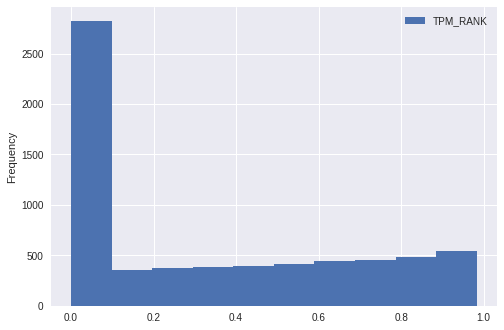

In [21]:
tpms_ranks.plot.hist(y='TPM_RANK')

In [22]:
tpms_ranks.describe()

,TPM,LOG_TPM,TPM_RANK
count,6656.000000,6656.000000,6656.000000
mean,22.228046,0.372169,0.333636
std,643.466588,0.567178,0.344605
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.136500,0.055569,0.233333
75%,2.696500,0.567791,0.650000
max,37325.000000,4.572011,0.983333


In [23]:
tpms_ranks['LEVEL'] = tpms_ranks.TPM_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks['AGE'] = 'ALL'
tpms_ranks['SEX'] = 'ALL'
tpms_ranks.head()

,ENSG,SMTSD,SEX,TPM,NCBI,HGNC,LOG_TPM,TPM_RANK,LEVEL,AGE
0,ENSG00000039139.9,Adipose - Subcutaneous,ALL,0.078,1767,DNAH5,0.032619,0.316667,Medium,ALL
1,ENSG00000039139.9,Adipose - Subcutaneous,ALL,0.074,1767,DNAH5,0.031004,0.250000,Medium,ALL
2,ENSG00000039139.9,Adipose - Visceral (Omentum),ALL,0.053,1767,DNAH5,0.022428,0.116667,Low,ALL
3,ENSG00000039139.9,Adipose - Visceral (Omentum),ALL,0.064,1767,DNAH5,0.026942,0.150000,Low,ALL
4,ENSG00000039139.9,Adrenal Gland,ALL,0.079,1767,DNAH5,0.033021,0.333333,Medium,ALL


In [24]:
tpms_ranks.LEVEL.value_counts().sort_index()

High            1251
Low              804
Medium          2050
Not detected    2551
Name: LEVEL, dtype: int64

### Compute TAU for each gene, stratified by sex:

In [25]:
tpms_tau_f = tpms.loc[tpms.SEX=='female'].groupby(['ENSG']).TPM.agg(TAU)
tpms_tau_f = pandas.DataFrame(tpms_tau_f).rename(columns={'TPM':'TAU_F'})
tpms_tau_f.head()

,TAU_F
ENSG,
ENSG00000039139.9,0.881320
ENSG00000082516.8,0.412861
ENSG00000100302.6,0.857392
ENSG00000100580.7,0.609194
ENSG00000101200.5,0.899435


In [26]:
tpms_tau_m = tpms.loc[tpms.SEX=='male'].groupby(['ENSG']).TPM.agg(TAU)
tpms_tau_m = pandas.DataFrame(tpms_tau_m).rename(columns={'TPM':'TAU_M'})
tpms_tau_m.head()

,TAU_M
ENSG,
ENSG00000039139.9,0.866073
ENSG00000082516.8,0.470625
ENSG00000100302.6,0.862967
ENSG00000100580.7,0.610741
ENSG00000101200.5,0.937310


In [27]:
tpms_tau = pandas.merge(tpms_tau_f, tpms_tau_m, left_index=True, right_index=True)
tpms_tau = tpms_tau.reset_index(drop=False)
tpms_tau.head()

,ENSG,TAU_F,TAU_M
0,ENSG00000039139.9,0.881320,0.866073
1,ENSG00000082516.8,0.412861,0.470625
2,ENSG00000100302.6,0.857392,0.862967
3,ENSG00000100580.7,0.609194,0.610741
4,ENSG00000101200.5,0.899435,0.937310


### Combine rows into one row per gene+tissue, cols for M and F TPM.

In [28]:
tpms_f = tpms.loc[tpms['SEX'] == 'female']
tpms_f = tpms_f[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_F'})
tpms_m = tpms.loc[tpms['SEX'] == 'male']
tpms_m = tpms_m[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_M'})
tpms_sex = pandas.merge(tpms_f, tpms_m, how='inner', on=['ENSG','SMTSD'])
tpms_sex.head()

,ENSG,SMTSD,TPM_F,TPM_M
0,ENSG00000039139.9,Adipose - Subcutaneous,0.078,0.074
1,ENSG00000039139.9,Adipose - Visceral (Omentum),0.053,0.064
2,ENSG00000039139.9,Adrenal Gland,0.079,0.079
3,ENSG00000039139.9,Artery - Aorta,0.083,0.072
4,ENSG00000039139.9,Artery - Coronary,0.064,0.066


In [29]:
t0 = time.time()
tpms_ranks_f = GTRanks(tpms_sex[['ENSG','SMTSD','TPM_F']].copy(), 'TPM_F')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks_f['LEVEL_F'] = tpms_ranks_f.TPM_F_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks_f.head()

Elapsed: 4s


,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F
0,ENSG00000039139.9,Adipose - Subcutaneous,0.078,0.266667,Medium
1,ENSG00000039139.9,Adipose - Visceral (Omentum),0.053,0.133333,Low
2,ENSG00000039139.9,Adrenal Gland,0.079,0.300000,Medium
3,ENSG00000039139.9,Artery - Aorta,0.083,0.333333,Medium
4,ENSG00000039139.9,Artery - Coronary,0.064,0.166667,Low


In [30]:
t0 = time.time()
tpms_ranks_m = GTRanks(tpms_sex[['ENSG','SMTSD','TPM_M']].copy(), 'TPM_M')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks_m['LEVEL_M'] = tpms_ranks_m.TPM_M_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks_m.head()

Elapsed: 4s


,ENSG,SMTSD,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000039139.9,Adipose - Subcutaneous,0.074,0.266667,Medium
1,ENSG00000039139.9,Adipose - Visceral (Omentum),0.064,0.133333,Low
2,ENSG00000039139.9,Adrenal Gland,0.079,0.366667,Medium
3,ENSG00000039139.9,Artery - Aorta,0.072,0.200000,Low
4,ENSG00000039139.9,Artery - Coronary,0.066,0.166667,Low


In [31]:
tpms_ranks = pandas.merge(tpms_ranks_f, tpms_ranks_m, on=['ENSG','SMTSD'], how='inner')
tpms_ranks.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000039139.9,Adipose - Subcutaneous,0.078,0.266667,Medium,0.074,0.266667,Medium
1,ENSG00000039139.9,Adipose - Visceral (Omentum),0.053,0.133333,Low,0.064,0.133333,Low
2,ENSG00000039139.9,Adrenal Gland,0.079,0.300000,Medium,0.079,0.366667,Medium
3,ENSG00000039139.9,Artery - Aorta,0.083,0.333333,Medium,0.072,0.200000,Low
4,ENSG00000039139.9,Artery - Coronary,0.064,0.166667,Low,0.066,0.166667,Low


### Log fold-change is log of ratio.

In [32]:
tpms_ranks['log2foldchange'] = ((tpms_ranks.TPM_F+1) / (tpms_ranks.TPM_M+1)).apply(numpy.log2)
tpms_ranks['log2foldchange_abs'] = tpms_ranks.log2foldchange.apply(numpy.abs)
tpms_ranks.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M,log2foldchange,log2foldchange_abs
0,ENSG00000039139.9,Adipose - Subcutaneous,0.078,0.266667,Medium,0.074,0.266667,Medium,0.005363,0.005363
1,ENSG00000039139.9,Adipose - Visceral (Omentum),0.053,0.133333,Low,0.064,0.133333,Low,-0.014993,0.014993
2,ENSG00000039139.9,Adrenal Gland,0.079,0.300000,Medium,0.079,0.366667,Medium,0.000000,0.000000
3,ENSG00000039139.9,Artery - Aorta,0.083,0.333333,Medium,0.072,0.200000,Low,0.014728,0.014728
4,ENSG00000039139.9,Artery - Coronary,0.064,0.166667,Low,0.066,0.166667,Low,-0.002709,0.002709


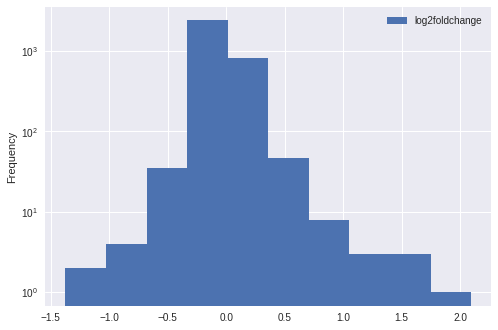

In [33]:
tpms_ranks.plot.hist(y='log2foldchange', logy=True)

### For selected tissue, sort genes by sex-difference magnitude:

In [38]:
tpms_bladder = tpms_ranks[tpms_ranks.SMTSD=="Bladder"]
tpms_bladder = tpms_bladder.sort_values(by=["log2foldchange_abs"], ascending=False)
tpms_bladder.drop(columns=['log2foldchange_abs'], inplace=True)
tpms_bladder = pandas.merge(tpms_bladder, genes, on="ENSG", how="left")
tpms_bladder = tpms_bladder.reset_index(drop=True)
tpms_bladder.head(10)


,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M,log2foldchange,NCBI,HGNC
0,ENSG00000163501.6,Bladder,0.963,0.766667,High,4.090,0.833333,High,-1.374605,3549,IHH
1,ENSG00000174807.3,Bladder,80.055,0.833333,High,38.685,0.533333,Medium,1.030307,57124,CD248
2,ENSG00000255398.2,Bladder,3.194,0.833333,High,6.316,0.833333,High,-0.802728,8843,HCAR3
3,ENSG00000152128.13,Bladder,3.030,0.700000,Medium,5.500,0.766667,High,-0.689660,81615,TMEM163
4,ENSG00000142619.4,Bladder,58.136,0.966667,High,89.910,0.966667,High,-0.620402,51702,PADI3
5,ENSG00000111432.4,Bladder,2.607,0.833333,High,4.409,0.866667,High,-0.584562,11211,FZD10
6,ENSG00000126458.3,Bladder,304.200,0.733333,Medium,205.800,0.633333,Medium,0.561519,6237,RRAS
7,ENSG00000235191.1,Bladder,0.698,0.900000,High,0.183,0.300000,Medium,0.521386,100874085,NUCB1-AS1
8,ENSG00000163132.6,Bladder,6.337,0.566667,Medium,9.371,0.700000,Medium,-0.499293,4487,MSX1
9,ENSG00000172938.3,Bladder,0.174,0.733333,Medium,0.547,0.866667,High,-0.398041,116512,MRGPRD


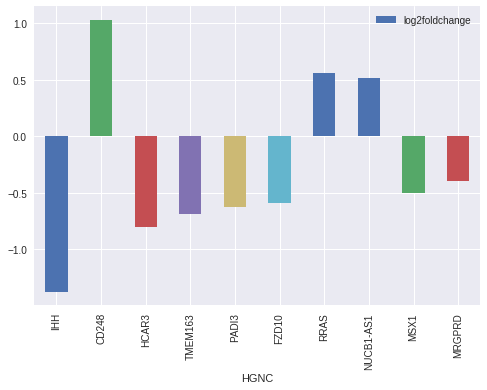

In [40]:
plotdata = tpms_bladder.iloc[0:10]
plotdata.plot.bar(y='log2foldchange', x='HGNC')

### For each gene, compute sex difference via Wilcoxon signed-rank test:
(Wilcoxon signed-rank test, with Wilcox treatment, discarding all zero-differences.)

In [41]:
results = pandas.DataFrame({'ENSG':tpms_sex.ENSG.drop_duplicates().sort_values(), 'WilcoxonSignedRank_stat':None, 'WilcoxonSignedRank_pval':None}).reset_index(drop=True)

for i in range(results.shape[0]):
  tpm_f_this = tpms_sex.TPM_F[tpms_ranks.ENSG==results.ENSG[i]]
  tpm_m_this = tpms_sex.TPM_M[tpms_ranks.ENSG==results.ENSG[i]]
  # Sample size must be sufficient.
  if tpm_f_this[tpm_f_this>0].size<8 or tpm_m_this[tpm_m_this>0].size<8:
    continue
  stat, pval = scipy.stats.wilcoxon(x=tpm_f_this, y=tpm_m_this, zero_method='wilcox')
  results.WilcoxonSignedRank_stat.iloc[i] = stat
  results.WilcoxonSignedRank_pval.iloc[i] = pval 
results.head()

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,ENSG,WilcoxonSignedRank_pval,WilcoxonSignedRank_stat
0,ENSG00000039139.9,0.910825,102
1,ENSG00000082516.8,0.219233,107
2,ENSG00000100302.6,0.78258,118
3,ENSG00000100580.7,0.696412,148
4,ENSG00000101200.5,0.303659,135
